In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42


In [23]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    
    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

In [3]:
# Load data

global_fits = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.061.analyze_fit_distributions/global_refit_results_withCs.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)


# get experimental info
main_db  = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/reference/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,buffer_id
0,1,-6.816452,-8.121080,-11.629118,0.953716,0.110213,0.0,9.961597,7,25,4U_a8c,1
1,2,-5.267578,-8.121080,-6.841065,0.917437,0.150436,0.0,0.531036,7,25,4U_a8c,1
2,3,-4.680462,-8.121080,-5.801307,0.938039,0.129168,0.0,0.288928,7,25,4U_a8c,1
3,5,-7.617252,-8.121080,-7.020689,0.684740,0.339345,0.0,0.137336,7,25,4U_a8c,1
4,6,-6.082823,-8.121080,-6.875103,0.920598,0.147028,0.0,0.238243,7,25,4U_a8c,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7272,9,-3.537457,-6.744415,-5.132881,0.992724,0.038891,0.0,0.149966,82,37,4U_wt,1
7273,25,-3.217183,-6.702464,-6.482345,0.999231,0.005345,0.0,0.077530,3,37,4U_wt,1
7274,25,-3.438874,-6.741250,-6.396819,0.996077,0.028552,0.0,0.416546,22,37,4U_wt,1
7275,25,-4.017535,-6.702023,-6.516996,0.991103,0.042777,0.0,0.413968,81,37,4U_wt,1


In [35]:
def fit_melting_curve(fits, construct, site, agg_mean = False):
    """
    Fit a melting curve for a given construct and site.

    Parameters:
        fits (pd.DataFrame): DataFrame containing the fit data.
        construct (str): The construct name to filter the data.
        site (int): The site number to filter the data.
        kadd_params (tuple): Tuple containing the slope and intercept of the kadd curve + extrapolated lnkadd value and error.

    Returns:
        tuple: A tuple containing:
            - fits_filt (pd.DataFrame): Filtered DataFrame for the given construct and site.
            - melt_result (lmfit.model.ModelResult): Result of the melting curve fit.
            - smooth_x (np.ndarray): Smoothed x-values for the fitted curve.
            - smooth_y (np.ndarray): Smoothed y-values for the fitted curve.
            - lnkobs_20C (float): Natural log of kobs at 20°C.
            - lnkobs_20C_err (float): Uncertainty in the natural log of kobs at 20°C.
            - lnkadd (float): Natural log of kadd at 20°C.
            - lnkadd_err (float): Uncertainty in the natural log of kadd at 20°C.
            - kadd_curve_x (np.ndarray): x-values for the kadd curve.
            - kadd_curve_y (np.ndarray): y-values for the kadd curve.
    
    """
    fits_filt = fits[(fits['disp_name'] == construct) & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    if agg_mean:
        fits_filt = fits_filt.groupby('temperature').mean().reset_index()


    aggregated_lmfit_melted(fits, sites, construct, fit_param = 'log_kobs')

    melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'], (kadd_slope, kadd_intercept))
    smooth_x, smooth_y = calc_smoothed_best_fit(melt_result)

    # calculate lnkobs at 20C
    lnkobs_20C = melt_result.eval(x = 1 / (273.15 + 20))
    lnkobs_20C_err = melt_result.eval_uncertainty(x = 1 / (273.15 + 20))

    # for drawing upper baseline
    slope = melt_result.params['c'].value
    intercept = melt_result.params['d'].value
    kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
    kadd_curve_y = slope * kadd_curve_x + intercept

    return fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y, 

### Individual k_add melt curve fit

In [36]:
# filter disp_name "4U_wt"
site = 8

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site)
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site)

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}C', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}C', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/ind_kadd_fit.pdf')
plt.show()

NameError: name 'aggregated_lmfit_melted' is not defined

### Plot ln(kobs) with linear fit (18A)

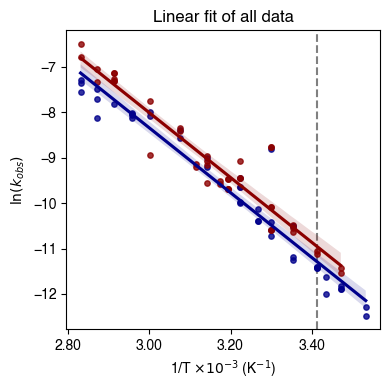

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

sns.regplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], scatter_kws={'s': 15})
sns.regplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], scatter_kws={'s': 15})
ax.axvline(1/(273.15 + 20), color='gray', linestyle='--', zorder = 0)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.set_title(f'Linear fit of all data')
plt.tight_layout()
#plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_all_linearkobs_fit.pdf')
plt.show()

### Aggregated fits of melted $k_{obs}$ for fourU thermometer

In [12]:
kadd_values = pd.read_csv('/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/06_aggfit_ntp_adduction/newcalc_kadd_arrhenius.csv')
kadd_values

,construct,lnkadd_20C,lnkadd_20C_err,slope,intercept,slope_err,intercept_err,group
0,4U,-11.884529,1.346197,8.733951,17.908926,2.454993,7.250740,A
1,4U,-10.917403,1.069046,7.243140,13.790562,1.964321,5.807700,C
2,hiv,-11.607447,1.730579,7.837125,15.126732,1.772358,5.105805,A
3,hiv,-11.378348,0.557491,3.812863,1.628177,0.610434,1.778903,C
4,nmr,-7.125879,0.198099,7.856410,19.674088,0.815301,2.626332,A
5,nmr,-7.602187,0.417477,10.844726,29.391590,1.649680,5.274908,C


### Representative 2-state melt

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


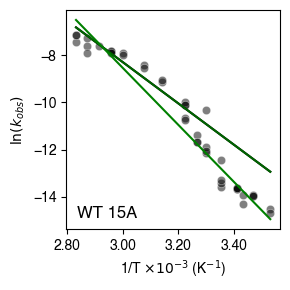

In [34]:
site = 15

# perform fits
kadd_params = kadd_values[(kadd_values['construct'] == '4U') & (kadd_values['group'] == 'A')][['slope', 'intercept', 'lnkadd_20C', 'lnkadd_20C_err']].values[0]
kadd_params[0] = kadd_params[0] * -1e3
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, kadd_params)
lower_baseline_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
lower_baseline_m = melt_result.params['a'].value
lower_baseline_b = melt_result.params['b'].value
lower_baseline_y = lower_baseline_m * lower_baseline_x + lower_baseline_b

# plot log_kappa vs 1/T (ax) and log_kobs vs 1/T (ax)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
formatter = FuncFormatter(thousands)

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color= 'black', alpha = 0.5, ax=ax)
ax.plot(smooth_x, smooth_y, color='black')
ax.plot(kadd_curve_x, kadd_curve_y, color='darkgreen')
ax.plot(lower_baseline_x, lower_baseline_y, color = 'green')
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.annotate(f'WT 15A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('representative_2statemelt_fit.pdf')
plt.show()

### Convergence

In [ ]:
# TO FIX agg_A_fit (no more)

def plot_n_save_2statemelt(fits, sites, base, ss_site, disp_name, agg_A_fit, label = None):
    # kadd_params = (agg_kadd_slope, agg_kadd_intercept)

    store_results = []
    kadd_params = (agg_A_fit['slope'].values[0], agg_A_fit['intercept'].values[0])

    # plot log_kappa vs 1/T (ax) and log_kobs vs 1/T (ax)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    formatter = FuncFormatter(thousands)
    for site in sites:
        # perform fits
        fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, disp_name, site, kadd_params)

        # store results
        store_results.append([site, disp_name, lnkobs_20C, lnkobs_20C_err])

        # plot 4U_wt
        sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', alpha = 0.15, ax=ax)
        ax.plot(smooth_x, smooth_y, label = site)

    melt_fits = pd.DataFrame(store_results, columns = ['site', 'disp_name', 'lnkobs_20C', 'lnkobs_20C_err'])
    melt_fits['lnkadd_20C'] = agg_A_fit['lnkadd_20C'].values[0]
    melt_fits['lnkadd_20C_err'] = agg_A_fit['lnkadd_20C_err'].values[0]
    melt_fits['base'] = 'A'

    if ss_site == None:
        # plot upper baseline
        ax.plot(kadd_curve_x, kadd_curve_y, color='black', label = r'agg. $k_{add}$')
    else:
        # plot site 18 (linear)
        fits_filt = fits[(fits['disp_name'] == disp_name) & (fits['site'] == ss_site)].copy()
        fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
        fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']
        m_18, b_18 = np.polyfit(fits_filt['inv_temp'], fits_filt['log_kobs'], 1)
        x_18 = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
        y_18 = m_18 * x_18 + b_18
        sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color= 'black', alpha = 0.5, ax=ax)
        ax.plot(x_18, y_18, color = 'black', label = 18)

    # vertical line at 20C
    ax.axvline(1/(273.15 + 20), color='gray', linestyle='--', alpha = 0.3, zorder = 0)

    ax.xaxis.set_major_formatter(formatter)
    ax.set_ylabel(r'$\ln(k_{obs})$')
    ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
    #ax.annotate(f'WT', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
    plt.legend(frameon = False, fontsize = 9)

    plt.tight_layout()
    if label == None:
        plt.savefig(f'{disp_name}_{base}_2statemelt_fits.pdf')
    else:
        plt.savefig(f'{disp_name}_{base}_2statemelt_fits_{label}.pdf')
    plt.show()

    return melt_fits

In [ ]:
melt_fits_wt = plot_n_save_2statemelt(fits, [7, 8, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_wt', agg_A_fit)
melt_fits_a8c = plot_n_save_2statemelt(fits, [7, 15, 16, 22, 26, 29, 34, 35], 'A', 18, '4U_a8c', agg_A_fit)
melt_fits_A = pd.concat([melt_fits_wt, melt_fits_a8c])

TypeError: plot_n_save_2statemelt() missing 1 required positional argument: 'agg_A_fit'

/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
/opt/homebrew/Caskroom/miniconda/base/envs/data_analysis/lib/python3.13/site-packages/lmfit/models.py:235: RankWarning: Polyfit may be poorly conditioned
  sval, oval = np.polyfit(x, data, 1)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


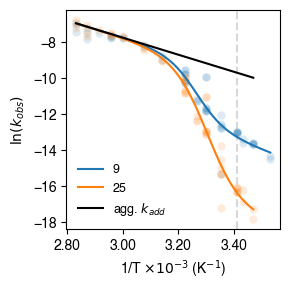

/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65361/1769102294.py:24: RuntimeWarning: divide by zero encountered in log
  final = np.log(fracu) * baseu + np.log(fracf) * basef
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65361/1769102294.py:17: RuntimeWarning: overflow encountered in exp
  K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
/var/folders/k7/k3x4cyj90rz6_py6pr8yth9m0000gn/T/ipykernel_65361/1769102294.py:20: RuntimeWarning: invalid value encountered in scalar divide
  fracf = K1 / Q1
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


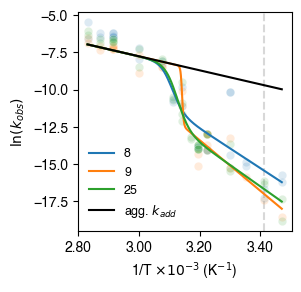

In [470]:
agg_C_fit = ACsites_df[(ACsites_df['index'] == 'aggregated') & (ACsites_df['base'] == 'C')]
melt_fits_wt = plot_n_save_2statemelt(fits, [9, 25], 'C', None, '4U_wt', agg_C_fit)
melt_fits_a8c = plot_n_save_2statemelt(fits, [8, 9, 25], 'C', None, '4U_a8c', agg_C_fit)
melt_fits_C = pd.concat([melt_fits_wt, melt_fits_a8c])

In [471]:
melt_fits_all = pd.concat([melt_fits_A, melt_fits_C])
melt_fits_all.to_csv('fourU_calc_lnkobs20.csv', index = False)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


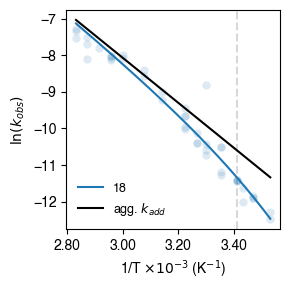

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


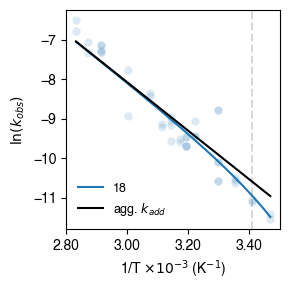

In [473]:
agg_A_fit = ACsites_df[(ACsites_df['index'] == 'aggregated') & (ACsites_df['base'] == 'A')]
melt_fits_wt = plot_n_save_2statemelt(fits, [18], 'A', None, '4U_wt', agg_A_fit, '18A')
melt_fits_a8c = plot_n_save_2statemelt(fits, [18], 'A', None, '4U_a8c', agg_A_fit, '18A')

### New energy calcs